---
# pRF frequency

This notebook aims to unravel the frequency domain of our pRF-design, on which we can then base our filtering operations

In [104]:
from linescanning import utils,prf,dataset,plotting
from pRFline import fitting
import numpy as np
import warnings
from mne import filter
import nibabel as nb
import matplotlib.pyplot as plt
from scipy import signal
import os
opj = os.path.join

warnings.simplefilter('ignore')
project_dir = os.environ.get("DIR_PROJECTS")
base_dir = os.path.join(project_dir, 'hemifield')
deriv_dir = opj(base_dir, 'derivatives')

plot_vox = 359
plot_xkcd = False
np.set_printoptions(precision=3)


In [102]:
# Load data
sub         = '003'
ses         = 4
task        = "task-pRF"
run         = [2,5]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
anat_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "anat")
prf_new     = opj(base_dir, 'derivatives', 'prf', f"sub-{sub}", f"ses-{ses}")

if not os.path.exists(prf_new):
    os.makedirs(prf_new, exist_ok=True)

Use `fitting.FitLines()`-class, which inherits from `linescanning.dataset.Dataset`, to read in the functional files, and average across runs and iterations

In [132]:
func_files = utils.get_file_from_substring(["task-pRF", "bold.mat"], func_dir, exclude="run-2")
physio_files = utils.get_file_from_substring(["task-pRF", "retroicor_timeseries.tsv"], func_dir, exclude="run-2")
mat_files = utils.get_file_from_substring(["task-pRF", "retroicor_timeseries.mat"], func_dir, exclude="run-2")
log_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/sourcedata/sub-003/ses-4/sub-003_ses-4_task-pRF_run-imgs"
model_fit = fitting.FitLines(func_files=func_files,
                             TR=0.105,
                             low_pass=False,
                             high_pass=True,
                             window_size=19,
                             poly_order=3,
                             log_dir=log_dir,
                             stage='grid+iter',
                             model='norm',
                             baseline_duration=20,
                             iter_duration=240,
                             n_iterations=2,
                             phys_file=physio_files,
                             phys_mat=mat_files,
                             verbose=True,
                             retroicor=True,
                             fmri_output="retroicor")

DATASET

PHYSIO
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_desc-retroicor_timeseries.tsv
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-5_desc-retroicor_timeseries.tsv
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-6_desc-retroicor_timeseries.tsv

FUNCTIONAL
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 RETROICOR with physio-regressors
(720, 5200)
 Using high-passed [DCT-filtered] data for PSC
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-5_bold.mat
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 RETROICOR with physio-regressor

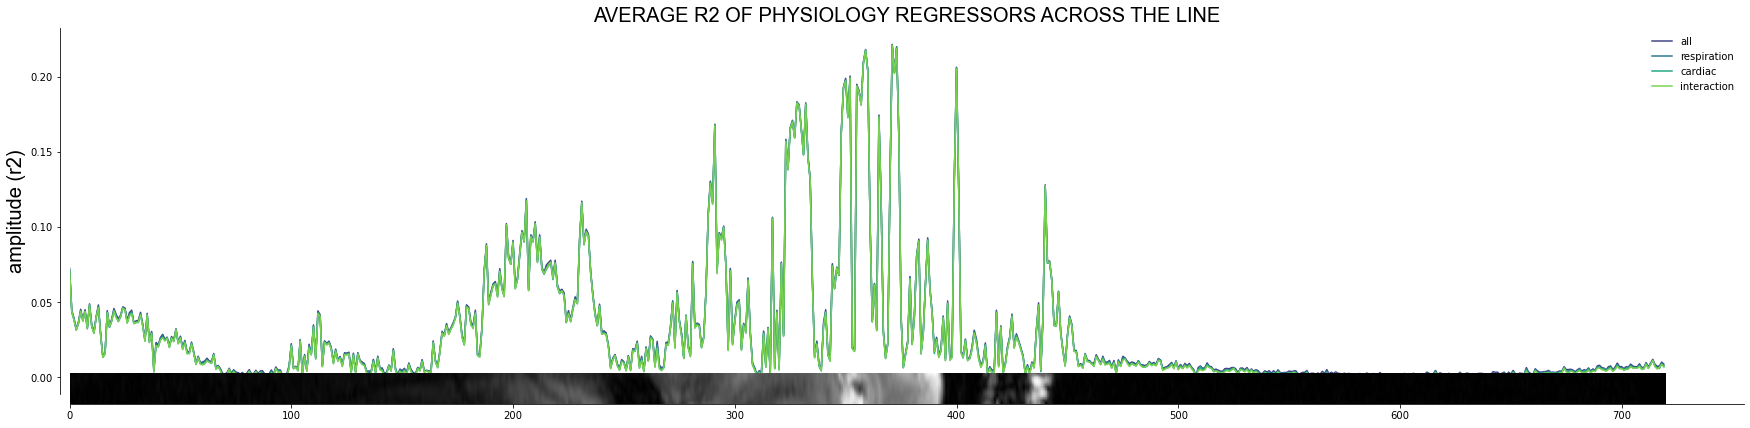

In [137]:
avg_r2 = model_fit.df_r2.groupby(['subject', 'vox']).mean()
cols = list(avg_r2.columns)
r2 = [avg_r2[item].values for item in cols]

fig = plt.figure(figsize=(30,10))
gs = fig.add_gridspec(2,1, hspace=-0.515)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot(r2, 
                  axs=ax1,
                  color="#1B9E77",
                  labels=cols,
                  y_label="amplitude (r2)",
                  title="Average r2 of physiology regressors across the line".upper(),
                  font_size=20,
                  line_width=1.5)

slice = utils.get_file_from_substring(['acq-1slice', 'run-2', 'nii.gz'], anat_dir)
slice_img = nb.load(slice)
slice_data = slice_img.get_fdata()

ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.imshow(np.rot90(np.squeeze(slice_data)[...,352:366]), cmap='Greys_r')
ax2.axis('off')

fname = opj(os.path.dirname(anat_dir), "r2_physio.pdf")
fig.savefig(fname)

Plot power spectrum:

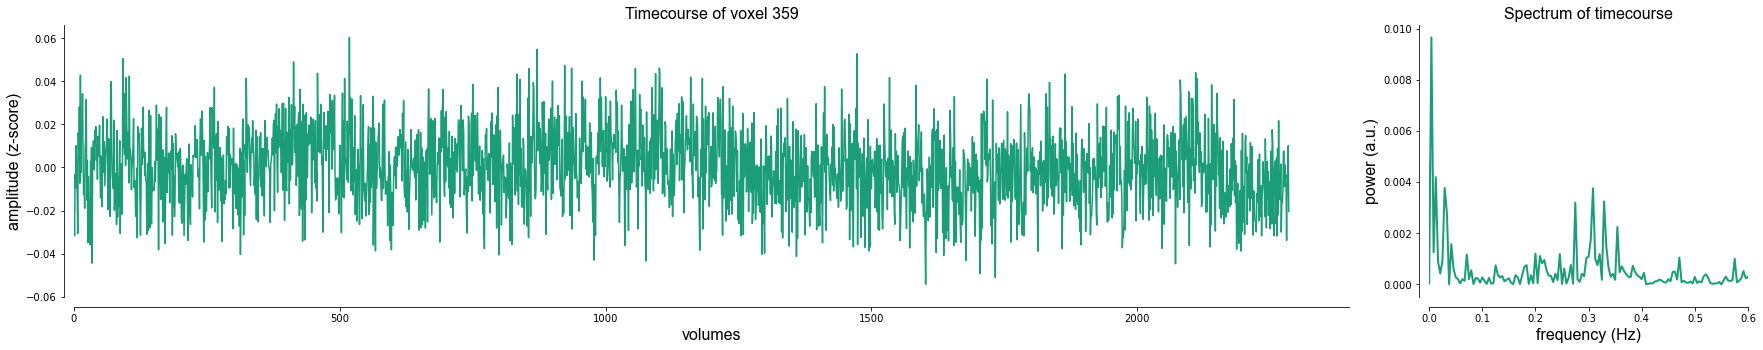

In [138]:
freq_type = "fft"
clipper = 5
tc1 = model_fit.avg_iters_no_baseline[:,359]

fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot(tc1, 
                  color="#1B9E77",
                  x_label="volumes",
                  y_label="amplitude (z-score)",
                  title="Timecourse of voxel 359",
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
task_freq = model_fit.get_freq(tc1, TR=0.105, spectrum_type=freq_type)

plotting.LazyPlot(task_freq[1],
                  xx=task_freq[0],
                  color="#1B9E77",
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  title="Spectrum of timecourse",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,0.6],
                  line_width=2)

fname = opj(os.path.dirname(anat_dir), "spectrum_after_retroicor.pdf")
fig.savefig(fname)

Apply `mne.filter.notch_filter`

In [108]:
Fs = 1/model_fit.TR
freqs = np.array((0.28, 1))
Fp1 = freqs[0] - 0.3 / 2
print(Fp1)


0.13000000000000003


In [109]:
notch_ = filter.notch_filter(tc1.astype(np.float64),
                             Fs,
                             freqs,
                             trans_bandwidth=0.2)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.10 Hz
- Upper transition bandwidth: 0.10 Hz
- Filter length: 315 samples (33.075 sec)



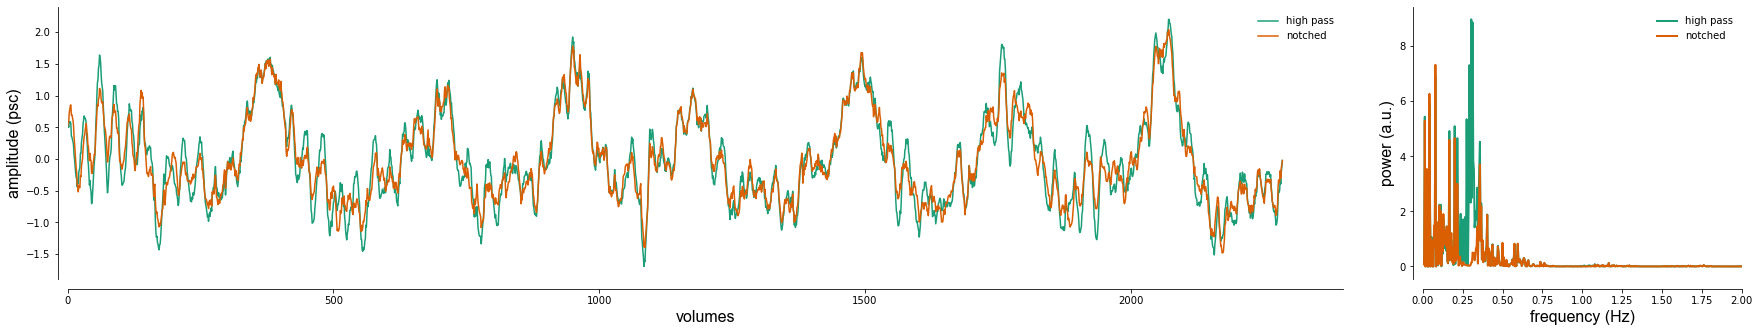

In [110]:
freq_type = "fft"
labels = ['high pass', 'notched']
clipper = 10
tc1 = model_fit.avg_iters_no_baseline[:,359]
tc2 = notch_

fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([tc1, tc2], 
                  labels=labels, 
                  color=["#1B9E77","#D95F02"],
                  x_label="volumes",
                  y_label="amplitude (psc)",                   
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
freq1 = model_fit.get_freq(tc1, TR=0.105, spectrum_type=freq_type, clip_power=clipper)
freq2 = model_fit.get_freq(tc2, TR=0.105, spectrum_type=freq_type, clip_power=clipper)

plotting.LazyPlot([freq1[1],freq2[1]],
                  xx=freq2[0],
                  color=["#1B9E77","#D95F02"], 
                  labels=labels, 
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,2],
                  line_width=2)

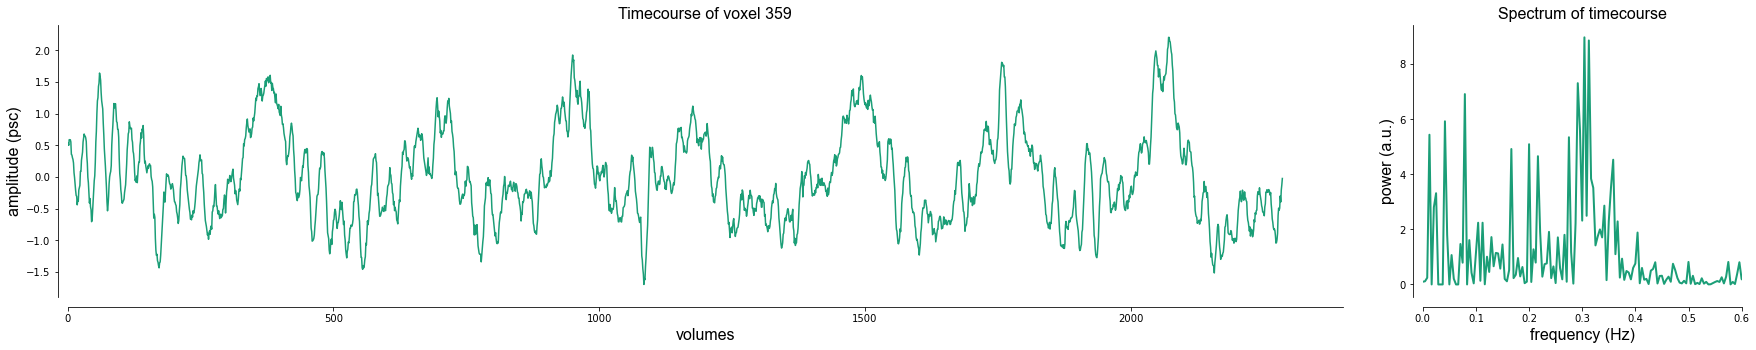

In [99]:
freq_type = "fft"
clipper = 5
tc1 = model_fit.avg_iters_no_baseline[:,359]

fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot(tc1, 
                  color="#1B9E77",
                  x_label="volumes",
                  y_label="amplitude (psc)",
                  title="Timecourse of voxel 359",
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
task_freq = model_fit.get_freq(tc1, TR=0.105, spectrum_type=freq_type, clip_power=10)

plotting.LazyPlot(task_freq[1],
                  xx=task_freq[0],
                  color="#1B9E77",
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  title="Spectrum of timecourse",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,0.6],
                  line_width=2)

In [101]:
notch_ = filter.notch_filter(tc1.astype(np.float64),
                             Fs,
                             freqs,
                             trans_bandwidth=0.2)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.10 Hz
- Upper transition bandwidth: 0.10 Hz
- Filter length: 315 samples (33.075 sec)



In [102]:
freq_type = "fft"
labels = ['low pass', 'notched']
clipper = 10
tc1 = model_fit.avg_iters_no_baseline[:,359]
tc2 = notch_

fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([tc1, tc2], 
                  labels=labels, 
                  color=["#1B9E77","#D95F02"],
                  x_label="volumes",
                  y_label="amplitude (psc)",                   
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
freq1 = model_fit.get_freq(tc1, TR=0.105, spectrum_type=freq_type, clip_power=clipper)
freq2 = model_fit.get_freq(tc2, TR=0.105, spectrum_type=freq_type, clip_power=clipper)

plotting.LazyPlot([freq1[1],freq2[1]],
                  xx=freq2[0],
                  color=["#1B9E77","#D95F02"], 
                  labels=labels, 
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,2],
                  line_width=2)

# Low-pass filter

In [98]:
model_fit = fitting.FitLines(func_files=func_files,
                             TR=0.105,
                             low_pass=True,
                             high_pass=True,
                             window_size=19,
                             poly_order=3,
                             log_dir=log_dir,
                             stage='grid+iter',
                             model='norm',
                             baseline_duration=20,
                             iter_duration=240,
                             n_iterations=2,
                             verbose=True)

Received:
/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-2_bold.mat
/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-5_bold.mat
/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-6_bold.mat
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-2_bold.mat
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filter [removes high frequences] (window = 19, order = 3)
 Using low-passed [SG-filtered] data for PSC
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 DCT-high pass filter [removes low frequencies <0.01 Hz]


## Raw, unfiltered data

In [10]:
run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
print(func_file)

window = 19
order = 3

func = dataset.Dataset(func_file,
                       deleted_first_timepoints=0, 
                       deleted_last_timepoints=0,
                       window_size=window, # needs to be odd
                       high_pass=True,
                       low_pass=True,
                       poly_order=order,
                       use_bids=True,
                       verbose=True)

raw = func.fetch_fmri(type='raw+psc')
avg_func = raw.groupby(['subject', 't']).mean()
print(avg_func.shape)
avg_func.head()


['/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-1_bold.mat', '/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat']
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-1_bold.mat
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filter [removes high frequences] (window = 19, order = 3)
 Using low-passed [SG-filtered] data for PSC
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filter [removes high frequences] (window = 19, order = 3)
 Using low-passed [SG-filtered] data for PSC
(5200, 720)


vox 0      vox 1     vox 2     vox 3      vox 4      vox 5  \
subject t                                                                       
003     0.000  -6.703946  -5.489987 -3.999764 -7.609015  -6.698087  -5.561990   
        0.105 -17.478317 -15.576088 -7.349792 -8.557942 -11.772854 -13.186878   
        0.210   3.198436  -6.507203  2.641726 -0.009486  -7.979369  -0.376219   
        0.315  -1.269057  -3.654331 -3.313717  3.129941  -2.420685  -6.843465   
        0.420   2.831197  -1.053190  7.172090  1.083967   3.025550  -4.292607   

                   vox 6      vox 7      vox 8     vox 9  ...    vox 710  \
subject t                                                 ...              
003     0.000 -14.622646  -5.119610 -10.680279 -4.474491  ...  -3.156400   
        0.105  -6.919283 -12.154990 -12.343370 -5.486446  ...  -5.611822   
        0.210   5.596423  -3.366709 -10.405073 -1.417506  ...   5.065474   
        0.315  -0.079677   6.763837  -8.434174 -5.614480  ... -24.381298   
        0.420   1.331049  -3.518701   7.780850 -2.753967  ...  14.221123   

                 vox 711    vox 712    vox 713    vox 714    vox 715  \
subject t                                                              
003     0.000 -15.802256  -4.068318   7.851547 -19.221436 -18.365280   
        0.105 -41.921276  -4.047960   7.955262  -2.405837 -11.850416   
        0.210 -17.711773  28.236412 -20.231934   9.772713   7.184178   
        0.315  -3.716731 -34.994862  -6.443540  -5.065188 -45.877800   
        0.420  25.426161 -24.869898 -10.114918 -31.956367   7.452077   

                 vox 716    vox 717    vox 718    vox 719  
subject t                                                  
003     0.000  -1.088443  17.830784  37.680138   9.117293  
        0.105   5.795681  -5.248672 -40.296494  14.275077  
        0.210  -9.638312   2.803719   0.195318   2.349213  
        0.315 -17.995892  31.584753  11.036936  17.192421  
        0.420  -7.757377   6.347513  11.152535  25.315119  

[5 rows x 720 columns]

In [11]:
plotting.LazyPlot(avg_func['vox 359'],
                  color="#000000",
                  line_width=2,
                  xkcd=plot_xkcd,
                  font_size=20)

In [4]:
n_iter = 3
iter_chunks = []
start = 286
iter_size = 1524
baseline = avg_func[:start]
for ii in range(n_iter):

    # try to fetch values, if steps are out of bounds, zero-pad the timecourse
    if start+iter_size < avg_func.shape[0]:
        chunk = avg_func.values[start:start+iter_size]
    else:
        chunk = avg_func.values[start+iter_size:]
        padded_array = np.zeros((iter_size, 720))
        padded_array[:chunk.shape[0]] = chunk
        chunk = padded_array.copy()

    iter_chunks.append(chunk[...,np.newaxis])
    start += iter_size
    print(f"Chunk size = {chunk.shape}")

avg_iters_baseline = np.concatenate((baseline, np.concatenate(iter_chunks, axis=-1).mean(axis=-1)))
avg_iters_no_baseline = np.concatenate(iter_chunks, axis=-1).mean(axis=-1)
print(f"Final func data (w/o baseline) has shape: {avg_iters_no_baseline.shape}")

Chunk size = (1524, 720)
Chunk size = (1524, 720)
Chunk size = (1524, 720)
Final func data (w/o baseline) has shape: (1524, 720)


findfont: Font family ['Humor Sans'] not found. Falling back to DejaVu Sans.


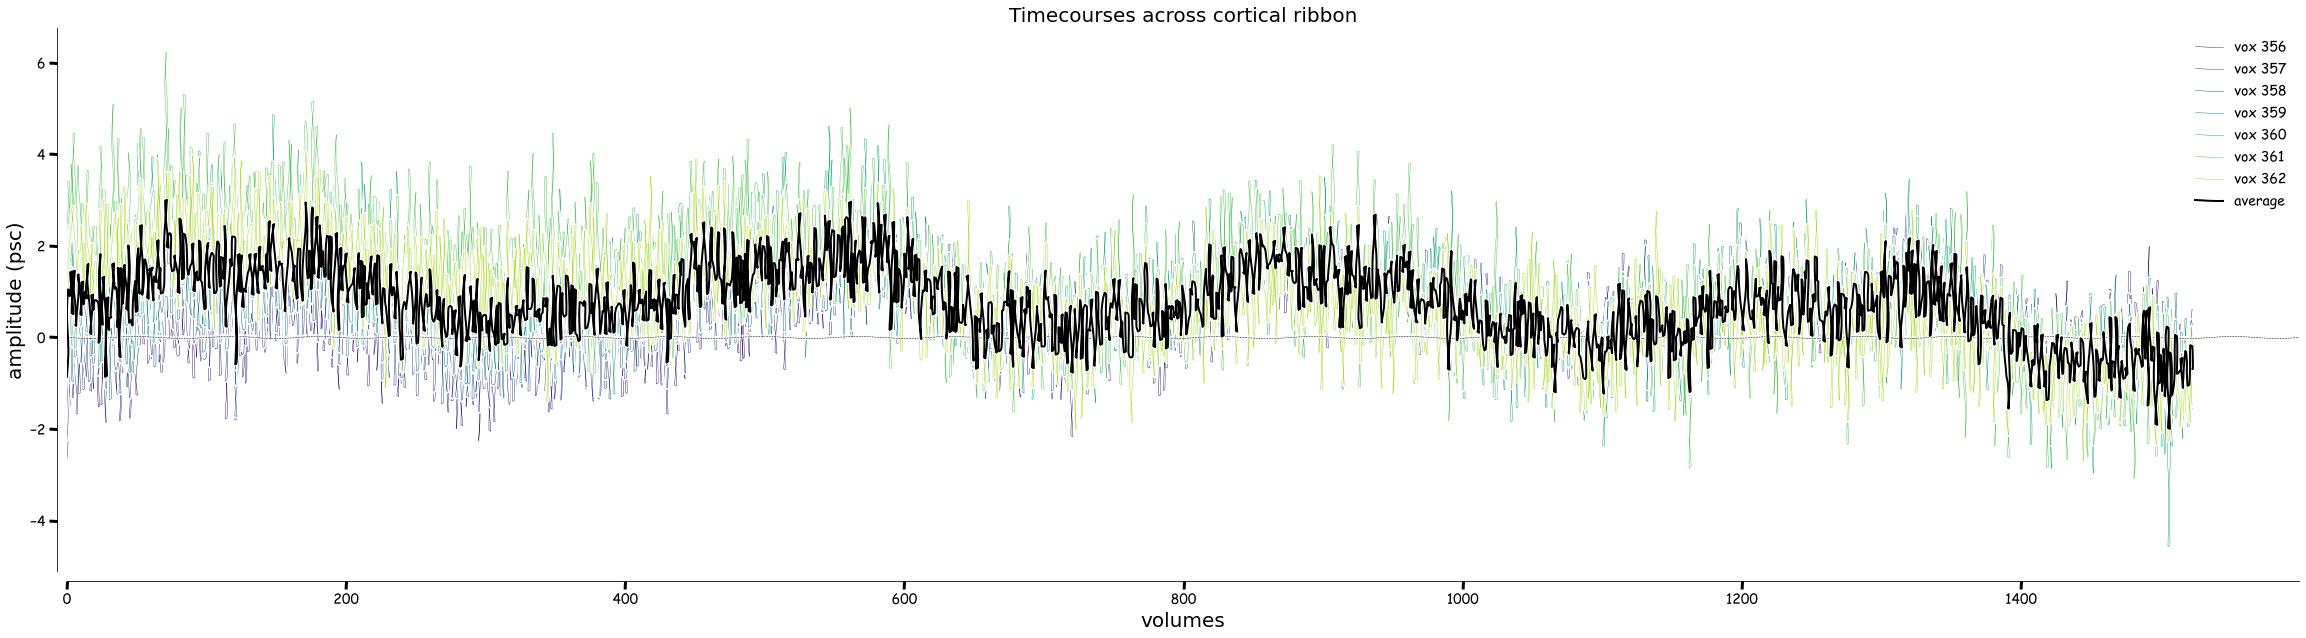

In [5]:
fig,axs = plt.subplots(figsize=(40,10))

ribbon      = [356,363]
include_vox = np.arange(*ribbon)
data = [avg_iters_no_baseline[:, ii] for ii in include_vox]

# get average across depth w/ different color
avg_ribbon = [ii[...,np.newaxis] for ii in data]
avg_ribbon = np.concatenate(avg_ribbon, axis=-1).mean(axis=-1)
avg_ribbon_unfilt = avg_ribbon.copy()
labels = [f'vox {ii}' for ii in include_vox]

# plot individual voxels
plotting.LazyPlot(data,
                  axs=axs,
                  x_label="volumes",
                  y_label="amplitude (psc)",
                  title="Timecourses across cortical ribbon",
                  labels=labels,
                  add_hline='default',
                  set_xlim_zero=True,
                  sns_trim=False,
                  line_width=0.5,
                  xkcd=plot_xkcd,
                  font_size=20)

# plot average
plotting.LazyPlot(avg_ribbon,
                 axs=axs,
                 color="#000000",
                 labels='average',
                 set_xlim_zero=True,
                 sns_trim=False,
                 line_width=2,
                 xkcd=plot_xkcd,
                 font_size=20)

ribbon_func = np.array(data)

In [6]:
# line pRF
log_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/prf_design/sub-003_ses-0_task-pRF_run-0"
design = prf.create_line_prf_matrix(log_dir, 
                                    stim_duration=0.25,
                                    nr_trs=avg_iters_baseline.shape[0],
                                    TR=0.105)
design = design[...,286:]                                    

In [7]:
ribbon_func = np.array(data)
use_model = "norm"

prf_lines = opj(prf_new, "sub-003_ses-3_task-pRF_model-norm_stage-iter_desc-prf_params.npy")
if not os.path.exists(prf_lines):
    print(f"Running fit")
    modelling = prf.pRFmodelFitting(ribbon_func, 
                                    design_matrix=design, 
                                    TR=0.105, 
                                    model=use_model, 
                                    stage='grid+iter', 
                                    verbose=True, 
                                    output_dir=prf_new,
                                    output_base="sub-003_ses-3_task-pRF",
                                    write_files=True)

    modelling.fit()
else:
    print(f"Loading parameter file {prf_lines}")
    yml = utils.get_file_from_substring([use_model, "settings"], prf_new)
    if isinstance(yml, list):
        yml = yml[-1]

    modelling = prf.pRFmodelFitting(ribbon_func,
                                    design_matrix=design,
                                    settings=yml,
                                    TR=0.105,
                                    model=use_model,
                                    output_dir=prf_new,
                                    output_base="sub-003_ses-3_task-pRF")

    modelling.load_params(np.load(prf_lines), model=use_model, stage='iter', acq='line')

Loading parameter file /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/sub-003_ses-3_task-pRF_model-norm_stage-iter_desc-prf_params.npy
Using settings file: /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/20220220_model-norm_desc-settings.yml


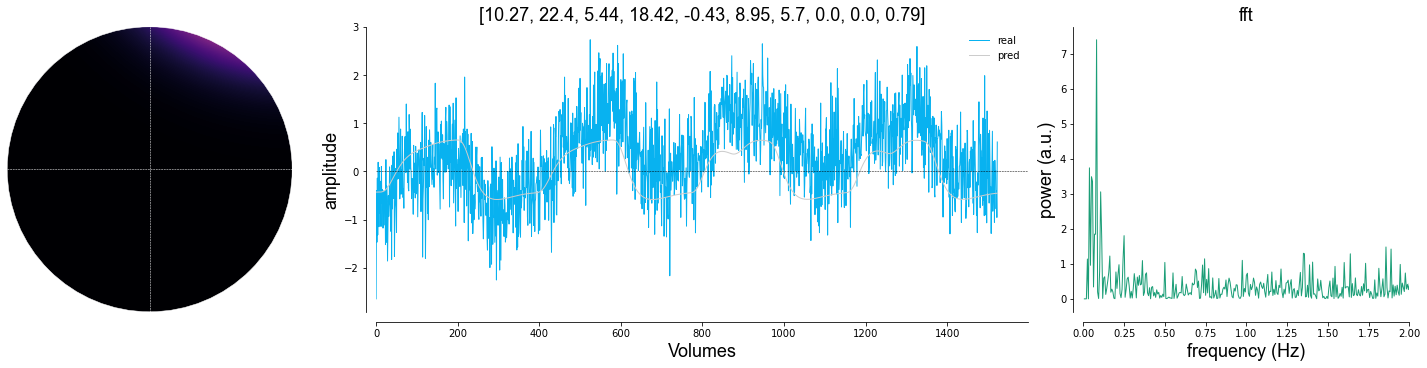

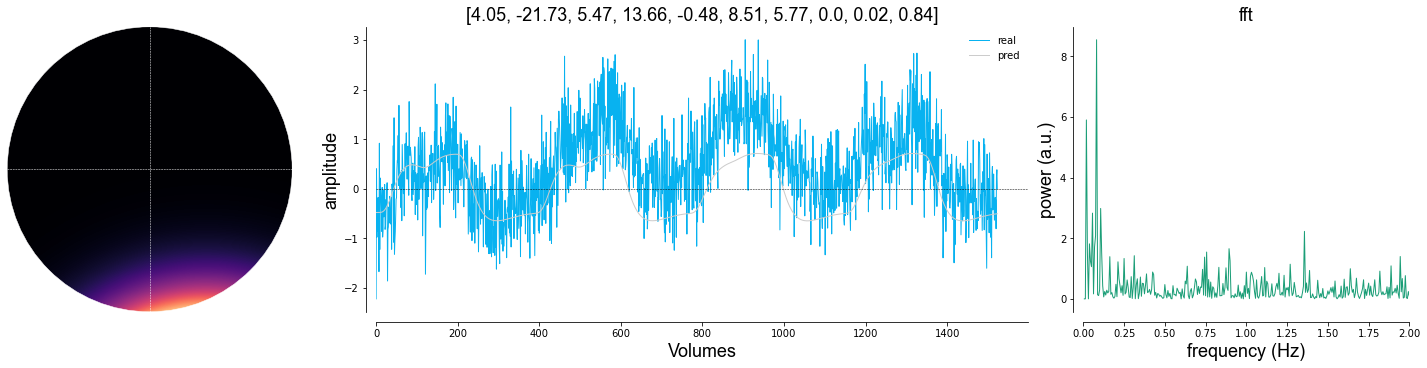

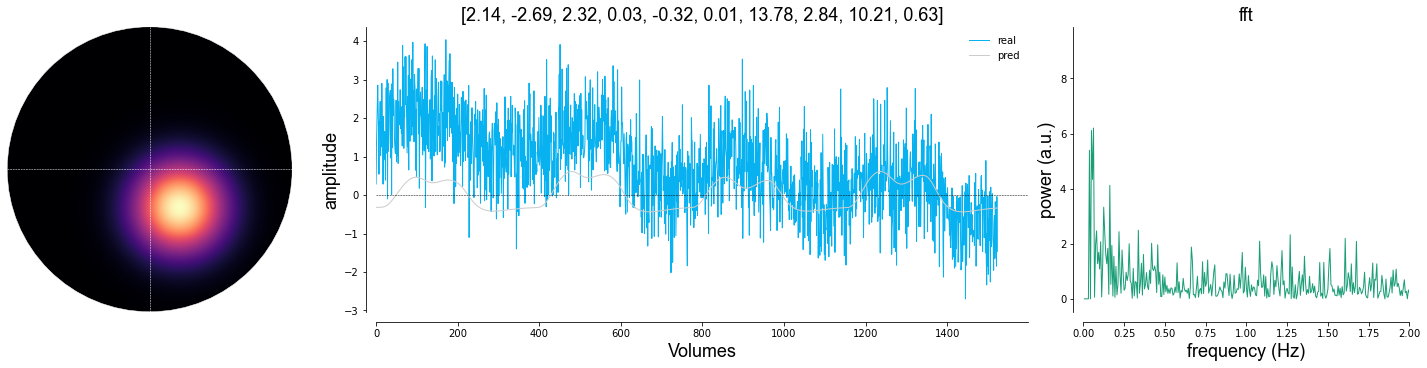

In [8]:
for vox_id in range(len(ribbon_func)):
    pars,_,_ = modelling.plot_vox(vox_nr=vox_id, model='norm', xkcd=False, title='pars', transpose=False, freq_spectrum=True, freq_type="fft", clip_power=10)

In [9]:
# freq_type = "fft"

# tc = ribbon_func[6,...]
# fs      = 1/0.105  # Sample frequency (Hz)
# cutoff  = 0.021
# b, a    = signal.iirnotch(cutoff, Q=0.005, fs = fs)

# filtered_data = signal.filtfilt(b, a, tc)
# print(filtered_data)

# fig = plt.figure(figsize=(30,5))
# gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

# ax1 = fig.add_subplot(gs[0])
# plotting.LazyPlot([tc, filtered_data], 
#                   labels=['no notch', 'notch'], 
#                   color=["#1B9E77","#D95F02"], 
#                   axs=ax1,
#                   line_width=1.5)

# ax2 = fig.add_subplot(gs[1])
# freq1 = dataset.ParseFuncFile.get_freq(tc, TR=0.105, spectrum_type=freq_type)
# freq2 = dataset.ParseFuncFile.get_freq(filtered_data, TR=0.105, spectrum_type=freq_type)

# plotting.LazyPlot([freq1[1],freq2[1]],
#                   xx=freq2[0],
#                   color=["#1B9E77","#D95F02"], 
#                   labels=['no notch', 'notch'],
#                   x_label="frequency (Hz)",
#                   y_label="power (a.u.)",
#                   axs=ax2,
#                   xkcd=False,
#                   font_size=16,
#                   set_xlim_zero=True,
#                   line_width=2)

## High/low-pass filtered

In [10]:
run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
print(func_file)

window = 19
order = 3

func = dataset.Dataset(func_file,
                       deleted_first_timepoints=0, 
                       deleted_last_timepoints=0,
                       window_size=window, # needs to be odd
                       high_pass=True,
                       low_pass=False,
                       poly_order=order,
                       use_bids=True,
                       verbose=True)

data = func.fetch_fmri()
avg_func = data.groupby(['subject', 't']).mean()
print(avg_func.shape)
avg_func.head()


['/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-pRF_run-2_bold.mat', '/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-pRF_run-5_bold.mat']
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-pRF_run-2_bold.mat
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Using high-passed [DCT-filtered] data for PSC
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-pRF_run-5_bold.mat
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Using high-passed [DCT-filtered] data for PSC
(4800, 720)


vox 0     vox 1      vox 2      vox 3     vox 4      vox 5  \
subject t                                                                      
003     0.000 -2.869928 -2.077931 -15.549409  -3.102767 -9.937784  -5.677542   
        0.105 -8.048147 -0.068256  -9.292159 -15.111521 -9.655288  -7.901767   
        0.210  1.767147  4.989147   7.560977   2.085844 -3.423241  10.196209   
        0.315  5.500608  5.892515   2.240115  -0.656751  2.138889   7.852512   
        0.420  1.321581  0.520319   5.326528  -5.286241  0.599593  -1.146209   

                   vox 6     vox 7      vox 8      vox 9  ...    vox 710  \
subject t                                                 ...              
003     0.000 -10.228562 -6.466910  -9.610838  -2.869925  ... -12.537092   
        0.105   4.162881 -6.144145  -1.259649 -17.752724  ...   9.026224   
        0.210  -3.158817 -2.328542   4.330426   6.867618  ...  -2.610764   
        0.315  -0.141746 -5.414081   3.473461  -1.256347  ... -25.537754   
        0.420   0.314456  1.916116 -10.222584  -6.573141  ...  -5.681347   

                 vox 711    vox 712    vox 713    vox 714    vox 715  \
subject t                                                              
003     0.000  24.190868 -16.077501 -21.932077  -6.405055  -5.380043   
        0.105 -37.360054 -10.027954 -23.382013 -22.910326 -21.295427   
        0.210  -3.021157 -27.976002 -26.706738 -35.633816 -18.723974   
        0.315 -17.186382  -6.697145 -11.831108   1.553351  -9.933877   
        0.420   8.790771  15.593550  -4.372203  15.437710 -13.728711   

                 vox 716    vox 717    vox 718    vox 719  
subject t                                                  
003     0.000 -13.195234 -12.672808  19.460266 -12.202170  
        0.105  41.471333  22.930187 -11.026112   1.160866  
        0.210 -30.733040 -14.862782  -6.128367 -15.334520  
        0.315   5.461902 -13.165596   8.076889 -18.501991  
        0.420 -15.407911   2.040357 -13.941693 -26.436533  

[5 rows x 720 columns]

In [11]:
n_iter = 3
iter_chunks = []
start = 286
iter_size = 1524
baseline = avg_func[:start]
for ii in range(n_iter):

    
    # try to fetch values, if steps are out of bounds, zero-pad the timecourse
    if start+iter_size < avg_func.shape[0]:
        chunk = avg_func.values[start:start+iter_size]
    else:
        chunk = avg_func.values[start+iter_size:]
        padded_array = np.zeros((iter_size, 720))
        padded_array[:chunk.shape[0]] = chunk
        chunk = padded_array.copy()

    iter_chunks.append(chunk[...,np.newaxis])
    start += iter_size
    print(f"Chunk size = {chunk.shape}")

avg_iters_baseline = np.concatenate((baseline, np.concatenate(iter_chunks, axis=-1).mean(axis=-1)))
avg_iters_no_baseline = np.concatenate(iter_chunks, axis=-1).mean(axis=-1)
print(f"Final func data (w/o baseline) has shape: {avg_iters_no_baseline.shape}")

Chunk size = (1524, 720)
Chunk size = (1524, 720)
Chunk size = (1524, 720)
Final func data (w/o baseline) has shape: (1524, 720)


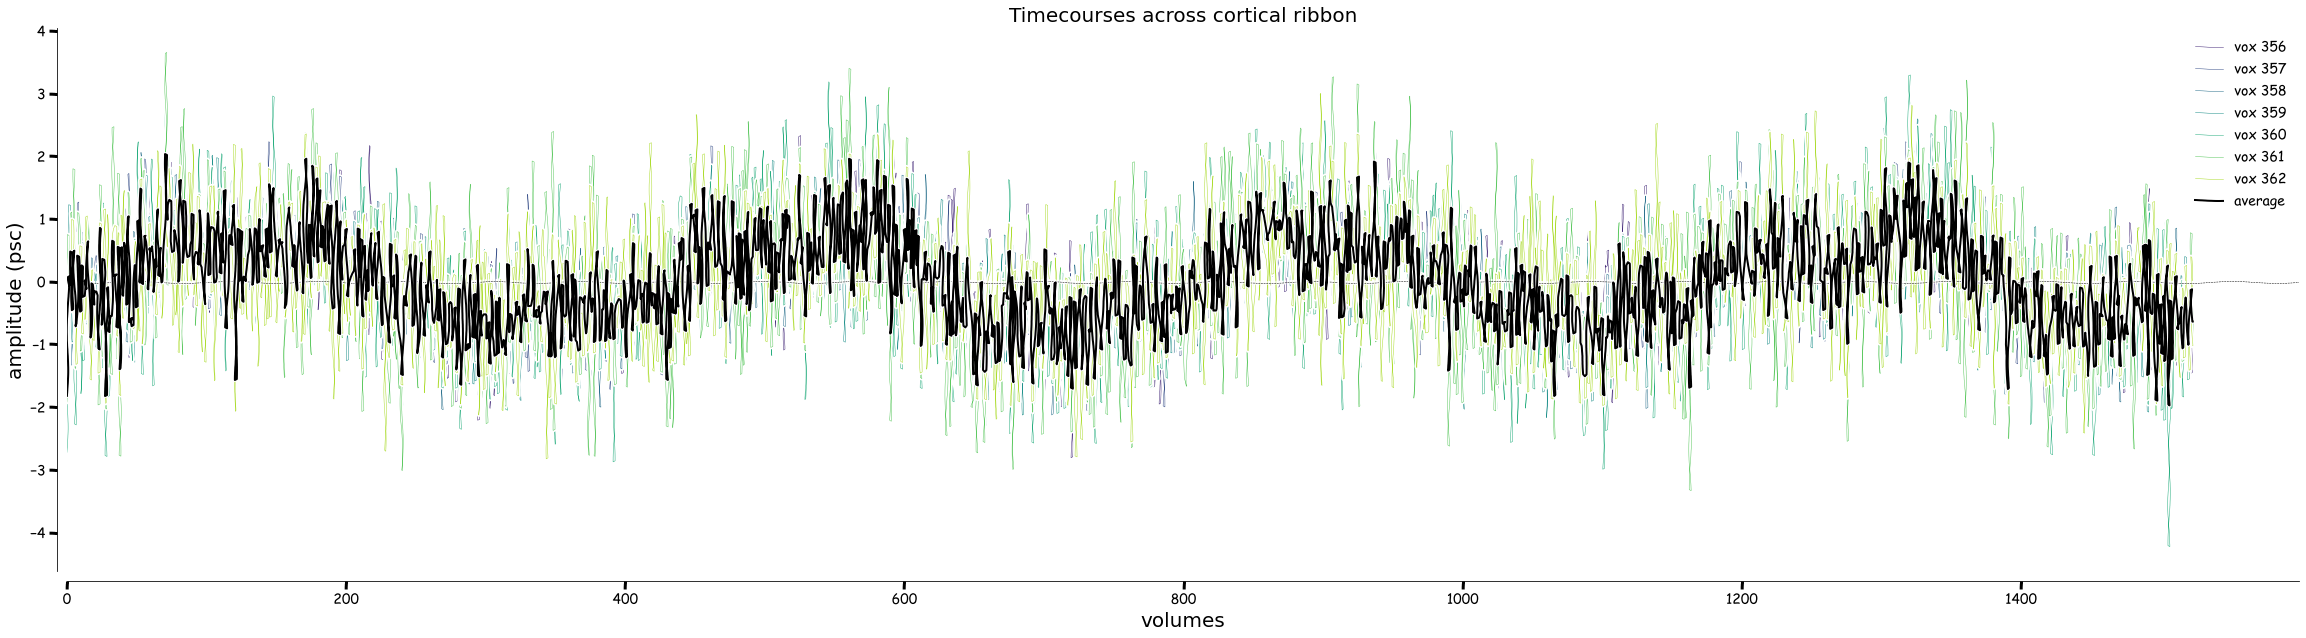

In [12]:
fig,axs = plt.subplots(figsize=(40,10))

ribbon      = [356,363]
include_vox = np.arange(*ribbon)
data = [avg_iters_no_baseline[:, ii] for ii in include_vox]

# get average across depth w/ different color
avg_ribbon = [ii[...,np.newaxis] for ii in data]
avg_ribbon = np.concatenate(avg_ribbon, axis=-1).mean(axis=-1)
avg_ribbon_filt = avg_ribbon.copy()
labels = [f'vox {ii}' for ii in include_vox]

# plot individual voxels
plotting.LazyPlot(data,
                  axs=axs,
                  x_label="volumes",
                  y_label="amplitude (psc)",
                  title="Timecourses across cortical ribbon",
                  labels=labels,
                  add_hline='default',
                  set_xlim_zero=True,
                  sns_trim=False,
                  line_width=0.5,
                  xkcd=plot_xkcd,
                  font_size=20)

# plot average
plotting.LazyPlot(avg_ribbon,
                 axs=axs,
                 color="#000000",
                 labels='average',
                 set_xlim_zero=True,
                 sns_trim=False,
                 line_width=2,
                 xkcd=plot_xkcd,
                 font_size=20)

ribbon_func_filt = np.array(data)                 

In [13]:
use_model = "norm"

prf_lines = opj(prf_new, "sub-003_ses-3_task-pRF_model-norm_stage-iter_desc-prf_params.npy")
if not os.path.exists(prf_lines):
    print(f"Running fit")
    modelling = prf.pRFmodelFitting(ribbon_func_filt, 
                                    design_matrix=design, 
                                    TR=0.105, 
                                    model=use_model, 
                                    stage='grid+iter', 
                                    verbose=True, 
                                    output_dir=prf_new,
                                    output_base="sub-003_ses-3_task-pRF",
                                    write_files=True)

    modelling.fit()
else:
    print(f"Loading parameter file {prf_lines}")
    yml = utils.get_file_from_substring([use_model, "settings"], prf_new)
    if isinstance(yml, list):
        yml = yml[-1]

    modelling = prf.pRFmodelFitting(ribbon_func_filt,
                                    design_matrix=design,
                                    settings=yml,
                                    TR=0.105,
                                    model=use_model,
                                    output_dir=prf_new,
                                    output_base="sub-003_ses-3_task-pRF")

    modelling.load_params(np.load(prf_lines), model=use_model, stage='iter', acq='line')

Loading parameter file /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/sub-003_ses-3_task-pRF_model-norm_stage-iter_desc-prf_params.npy
Using settings file: /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/20220220_model-norm_desc-settings.yml


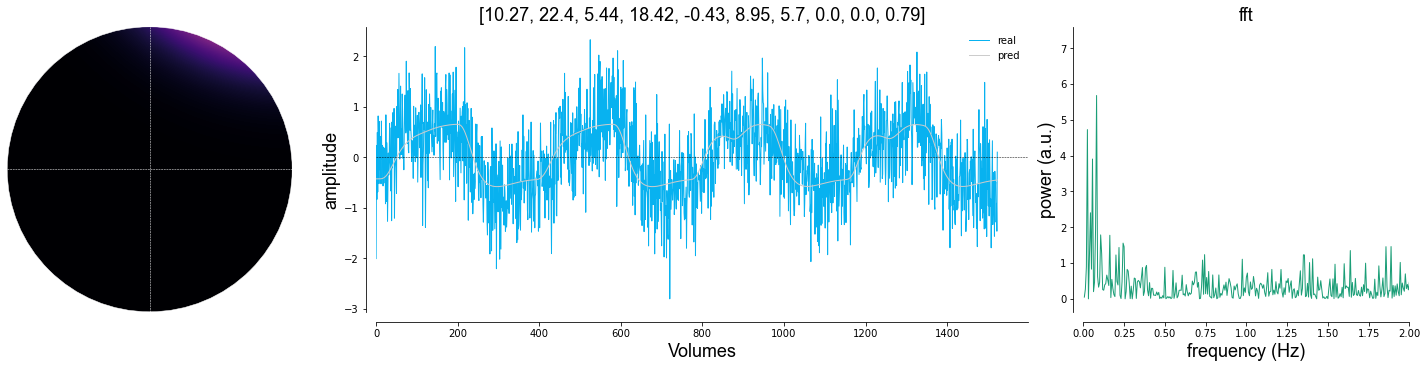

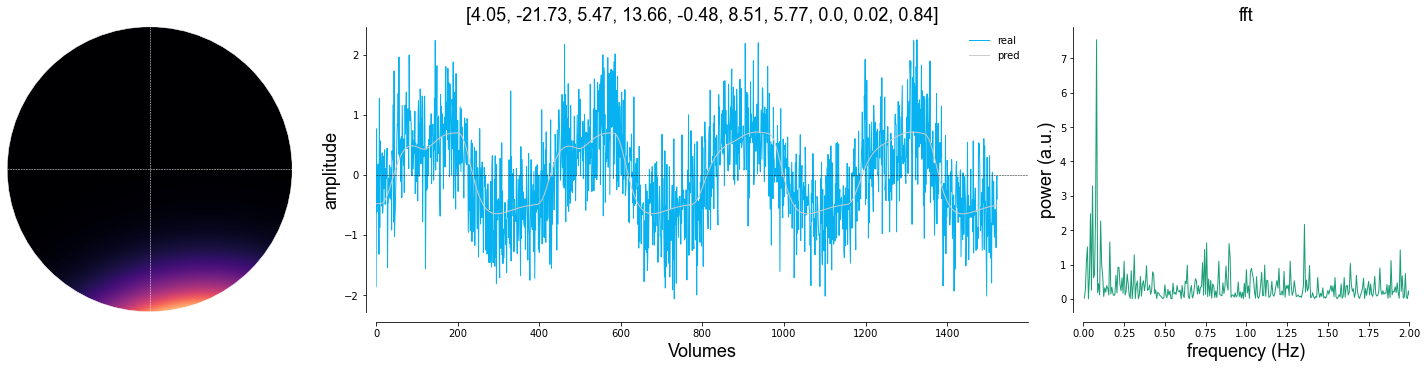

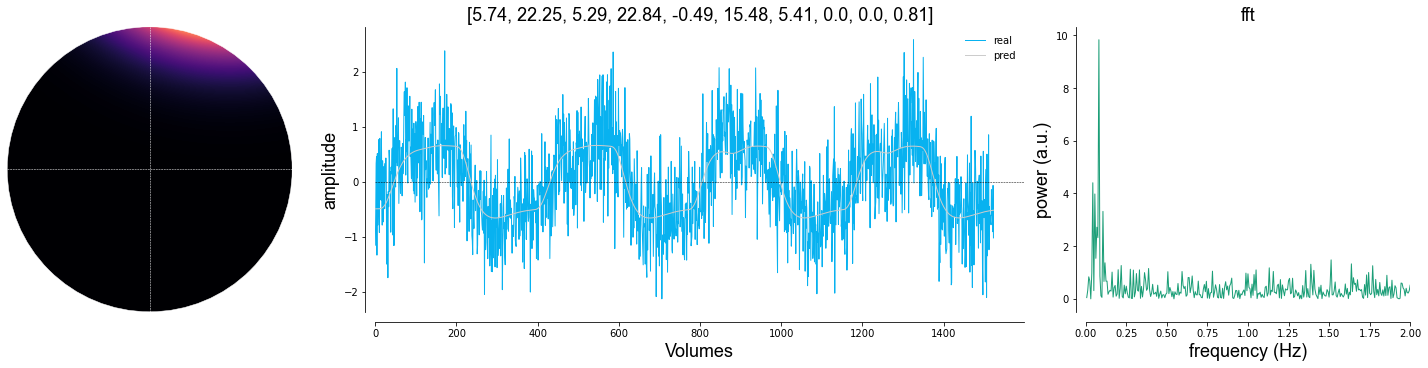

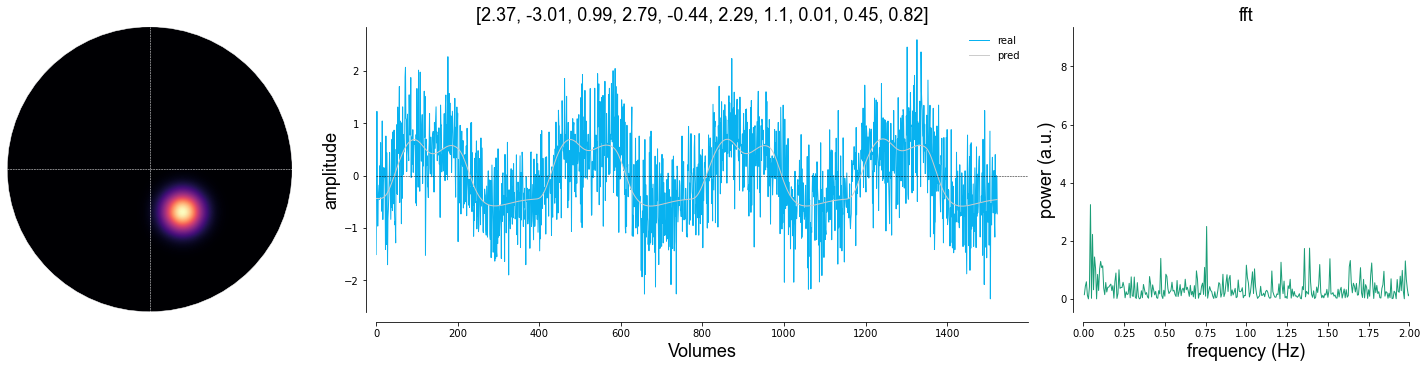

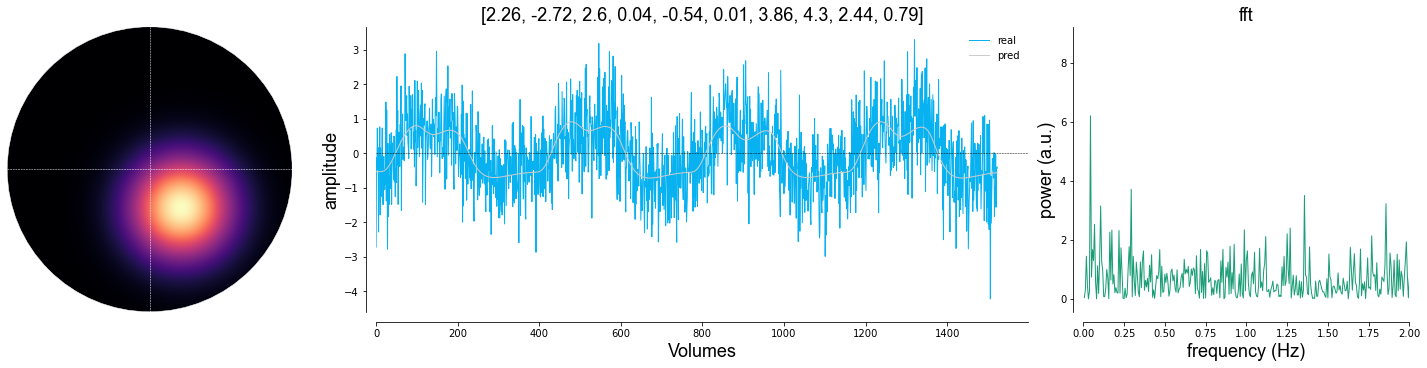

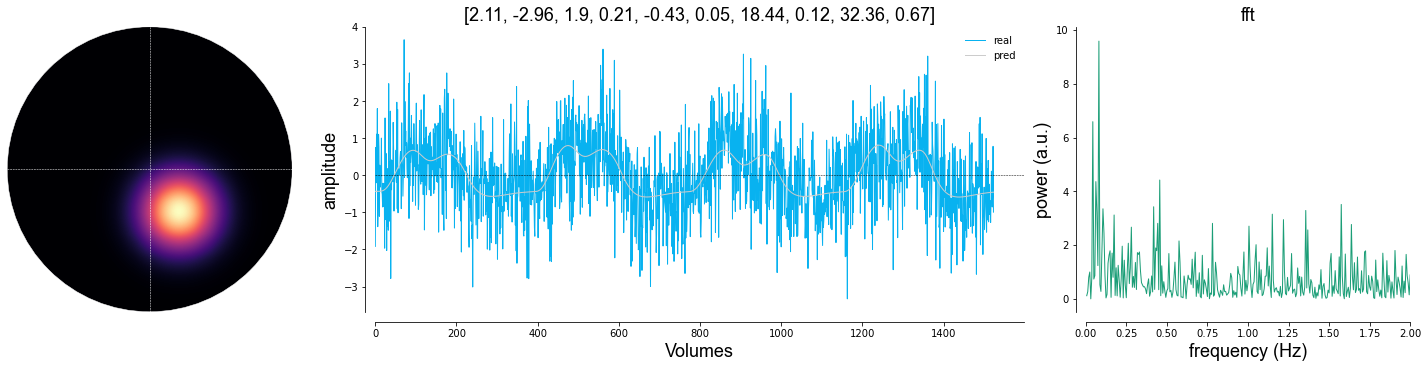

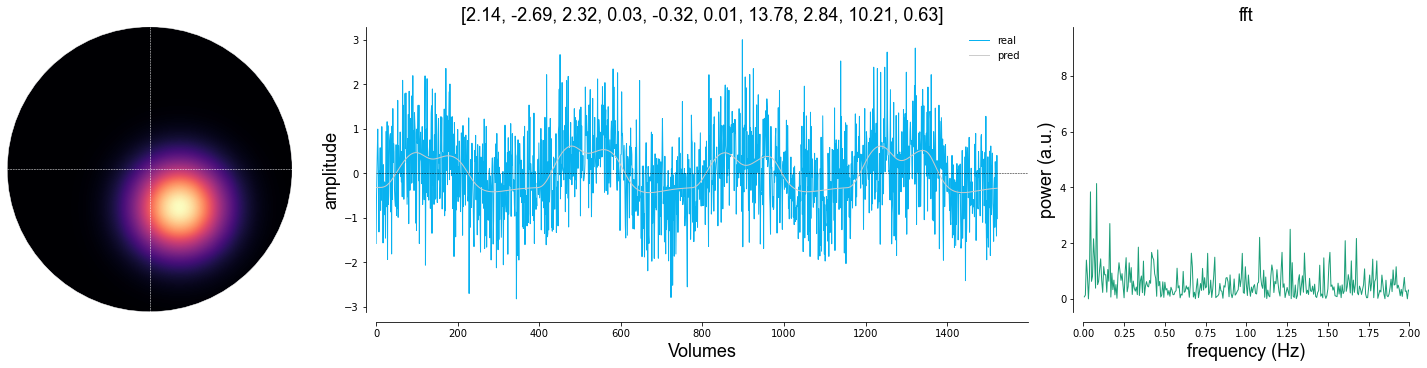

In [14]:
for vox_id in range(len(ribbon_func)):
    pars,_,_ = modelling.plot_vox(vox_nr=vox_id, model='norm', xkcd=False, title='pars', transpose=False, freq_spectrum=True, freq_type="fft", clip_power=10)

In [15]:
# freq_type = "fft"
# if freq_type == "fft":
#     clip = True
# else:
#     clip = False

# tc = ribbon_func_filt[6,...]
# fs      = 1/0.105  # Sample frequency (Hz)
# cutoff  = 1.01
# b, a    = signal.iirnotch(cutoff, Q=0.005, fs=fs)

# filtered_data = signal.filtfilt(b, a, tc)
# print(filtered_data)

# fig = plt.figure(figsize=(30,5))
# gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

# ax1 = fig.add_subplot(gs[0])
# plotting.LazyPlot([tc, filtered_data], 
#                   labels=['no notch', 'notch'], 
#                   color=["#1B9E77","#D95F02"], 
#                   axs=ax1,
#                   line_width=1.5)

# ax2 = fig.add_subplot(gs[1])
# freq1 = dataset.ParseFuncFile.get_freq(tc, TR=0.105, spectrum_type=freq_type)
# freq2 = dataset.ParseFuncFile.get_freq(filtered_data, TR=0.105, spectrum_type=freq_type)

# plotting.LazyPlot([freq1[1],freq2[1]],
#                   xx=freq2[0],
#                   color=["#1B9E77","#D95F02"], 
#                   labels=['no notch', 'notch'],
#                   x_label="frequency (Hz)",
#                   y_label="power (a.u.)",
#                   axs=ax2,
#                   xkcd=False,
#                   font_size=16,
#                   set_xlim_zero=True,
#                   line_width=2)

In [16]:
freq_type = "fft"
labels = ['no filter', 'high pass']
clipper = 5
tc1 = avg_ribbon_unfilt
tc2 = avg_ribbon_filt

fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([tc1, tc2], 
                  labels=labels, 
                  color=["#1B9E77","#D95F02"],
                  x_label="volumes",
                  y_label="amplitude (psc)",                   
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
freq1 = dataset.ParseFuncFile.get_freq(tc1, TR=0.105, spectrum_type=freq_type, clip_power=clipper)
freq2 = dataset.ParseFuncFile.get_freq(tc2, TR=0.105, spectrum_type=freq_type, clip_power=clipper)

plotting.LazyPlot([freq1[1],freq2[1]],
                  xx=freq2[0],
                  color=["#1B9E77","#D95F02"], 
                  labels=labels, 
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,2],
                  line_width=2)

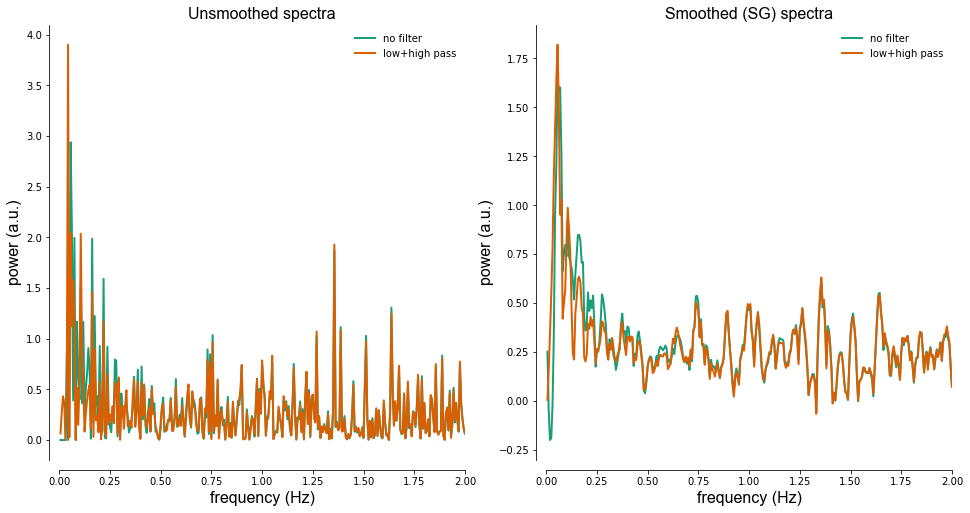

In [17]:
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([freq1[1], freq2[1]],
                  xx=freq2[0],
                  color=["#1B9E77","#D95F02"], 
                  labels=['no filter', 'low+high pass'], 
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  axs=ax1,
                  title="Unsmoothed spectra",
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,2],
                  line_width=2)

ax2 = fig.add_subplot(gs[1])
window = 9
order = 2
sg_freq1 = dataset.ParseFuncFile.lowpass_savgol(freq1[1], window_length=window, polyorder=order)
sg_freq2 = dataset.ParseFuncFile.lowpass_savgol(freq2[1], window_length=window, polyorder=order)
plotting.LazyPlot([sg_freq1, sg_freq2],
                  xx=freq2[0],
                  color=["#1B9E77","#D95F02"], 
                  labels=['no filter', 'low+high pass'], 
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  axs=ax2,
                  title="Smoothed (SG) spectra",
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,2],
                  line_width=2)

# Task frequency

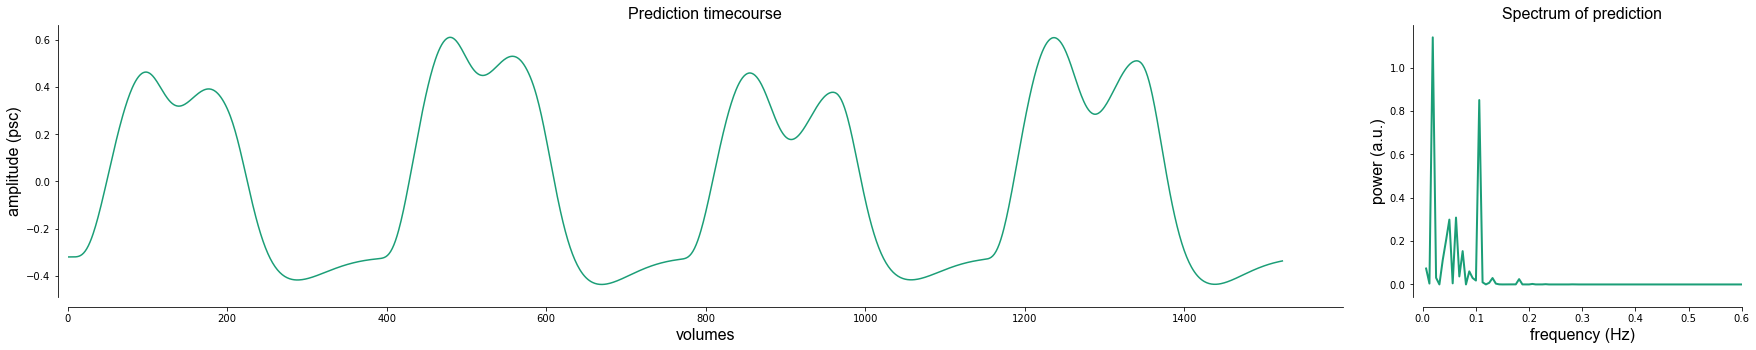

In [18]:
freq_type = "fft"
clipper = 5
tc1 = modelling.prediction.copy()

fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot(tc1, 
                  color="#1B9E77",
                  x_label="volumes",
                  y_label="amplitude (psc)",
                  title="Prediction timecourse",
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
task_freq = dataset.ParseFuncFile.get_freq(tc1, TR=0.105, spectrum_type=freq_type, clip_power=clipper)

plotting.LazyPlot(task_freq[1],
                  xx=task_freq[0],
                  color="#1B9E77",
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  title="Spectrum of prediction",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,0.6],
                  line_width=2)

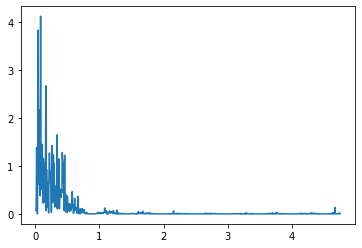

In [213]:
func = tc1.copy()
from scipy import fft
TR              = 0.105
sampling_rate   = 1/TR
N               = func.shape[0]
power           = fft.fft(func)
freq            = fft.fftfreq(N, 1/sampling_rate)
clip_power      = 60 # set power above to 0 (removes big bumpy at 0Hz)

power = np.abs(fft.fft(func))**2/func.shape[0]

# clip negative frequencies
freq = freq[freq>0]
power = power[:freq.shape[0]]

# clip power to remove bump as 0Hz
power[power>clip_power] = 0

plt.plot(freq,power)